#**Proyek Model Sistem Rekomendasi : Sistem Rekomendasi Anime**

by : Baharuddin Nur Maulana

Import Library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import zipfile
import os
import re
import warnings
warnings.filterwarnings('ignore')

#**CONTENT BASED FILTERING**

##**Data Understanding**

Import Dataset

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baharuddinnurm","key":"dfbbd9dfa2f0bc24956bc3c4ff6092ae"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 88% 22.0M/25.0M [00:00<00:00, 80.4MB/s]
100% 25.0M/25.0M [00:00<00:00, 80.4MB/s]


In [7]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [8]:
df_anime = pd.read_csv('/content/anime.csv')

Melakukan pengecekan missing value dengan fungsi isnull()

In [9]:
df_anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Dari informasi diatas, menunjukkan terjadinya missing value pada beberapa kolom  dataset diatas diantaranya pada kolom genre, type dan rating.

In [10]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [11]:
df_anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [12]:
df_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


Dari hasil dataset yang dihasilkan diatas, kita dapat mengetahui bahwa dataset tersebut memiliki 12294 baris dan 7 kolom

Visualisasi Data

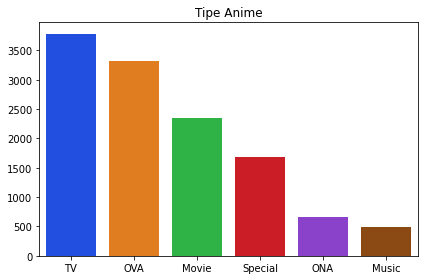

In [13]:
type_count = df_anime['type'].value_counts()
sns.barplot(x=type_count.index,
            y=type_count.values, 
            palette='bright').set_title('Tipe Anime')
plt.tight_layout()
plt.show()

Pada hasil grafik diatas, menunjukkan bahwa tipe anime di Tv lebih tinggi(> 3500) dibandingkan tipe anime yang lain, dan music menunjukkan tipe anime paling rendah (< 500).

##**Data Preparation**

Melakukan penangan missing value pada kolom genre, type dan rating menggunakan fungsi dropna()

In [14]:
df_anime.dropna(inplace = True)

In [15]:
df_anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [16]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [17]:
df_anime['rating'].value_counts()

6.00    141
7.00     98
6.50     90
6.25     84
5.00     76
       ... 
3.47      1
3.71      1
3.87      1
3.91      1
3.14      1
Name: rating, Length: 598, dtype: int64

In [18]:
df_anime['type'].value_counts()

TV         3668
OVA        3284
Movie      2259
Special    1670
ONA         648
Music       488
Name: type, dtype: int64

In [19]:
df_anime['genre'].value_counts()

Hentai                                                   816
Comedy                                                   521
Music                                                    297
Kids                                                     197
Comedy, Slice of Life                                    174
                                                        ... 
Adventure, Comedy, Horror, Shounen, Supernatural           1
Comedy, Harem, Romance, School, Seinen, Slice of Life      1
Comedy, Ecchi, Sci-Fi, Shounen                             1
Adventure, Shounen, Sports                                 1
Hentai, Slice of Life                                      1
Name: genre, Length: 3229, dtype: int64

###Text Cleaning

Menghilangkan simbol/karakter yang tidak diperlukan menggunakan fungsi text cleaning.

In [20]:
def text_cleaning(teks):
    teks = re.sub(r'&amp;', 'and', teks)
    teks = re.sub(r'I&3039;', 'I\'', teks)
    teks = re.sub(r'&quot;', '', teks)
    teks = re.sub(r'.hack//', '', teks)
    teks = re.sub(r'&#039;', '', teks)
    teks = re.sub(r'A&#039;s', '', teks)
    teks = teks.replace('...', '')
    teks = teks.replace(':', '')
    teks = teks.replace('None', '')
    
    return teks
df_anime['name'] = df_anime['name'].apply(text_cleaning)

In [21]:
df_anime['name']

0                                           Kimi no Na wa.
1                          Fullmetal Alchemist Brotherhood
2                                                 Gintama°
3                                              Steins;Gate
4                                                  Gintama
                               ...                        
12289          Toushindai My Lover Minami tai Mecha-Minami
12290                                          Under World
12291                       Violence Gekiga David no Hoshi
12292    Violence Gekiga Shin David no Hoshi Inma Densetsu
12293                      Yasuji no Pornorama Yacchimae!!
Name: name, Length: 12017, dtype: object

In [22]:
df_anime['name'].unique()

array(['Kimi no Na wa.', 'Fullmetal Alchemist Brotherhood', 'Gintama°',
       ..., 'Violence Gekiga David no Hoshi',
       'Violence Gekiga Shin David no Hoshi Inma Densetsu',
       'Yasuji no Pornorama Yacchimae!!'], dtype=object)

#**Modelling & Result**

In [23]:
#Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

#Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(df_anime['genre'])


In [24]:
#Melihat ukuran matrix tfidf
tfidf_matrix.shape

(12017, 47)

In [25]:
#Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29498527, 0.3162867 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2516182 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

#Menghiitung cosine similitary pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14715318, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14715318, 1.        , 0.17877808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17877808, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [27]:
#Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_anime['name'], columns=df_anime['name'])

#Melihat similarity matrix pada setiap anime
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)                     

name,Hayate no Gotoku! Cant Take My Eyes Off You,Okawari-Boy Starzan S,Hot Minute Gudetama,Pupa,Injoku no Heya,Yawara! Sore Yuke Koshinuke Kids!!,Ai Monogatari 9 Love Stories,Sayonara Zetsubou Sensei Special,Kimi ga Nozomu Eien,Sono Hanabira ni Kuchizuke wo Reo x Mai Diaries
name,,,,,,,,,,
Duel Masters Hamukatsu to Dogiragon no Curry-pan Daibouken,0.337237,0.485383,0.212327,0.000000,0.000000,0.177239,0.000000,0.119598,0.000000,0.090222
Asobi ni Iku yo! Asobi ni Oide - Owari,0.269199,0.000000,0.545869,0.000000,0.000000,0.176856,0.000000,0.307473,0.000000,0.231950
Zukkoke Sannin-gumi Zukkoke Jikuu Bouken,0.092063,0.501976,0.186680,0.000000,0.000000,0.060483,0.000000,0.105152,0.000000,0.079324
Urashima Tarou (1931),0.000000,0.462340,0.000000,0.000000,0.000000,0.222055,0.000000,0.000000,0.000000,0.000000
Makai Toshi Shinjuku,0.154655,0.172653,0.000000,0.369159,0.279834,0.115514,0.305861,0.000000,0.181042,0.151499
Good Morning,0.000000,0.000000,0.000000,0.000000,0.000000,0.433185,0.000000,0.000000,0.678919,0.000000
Shingeki no Kyojin,0.144248,0.140074,0.000000,0.122010,0.000000,0.154141,0.230006,0.000000,0.136142,0.000000
Yama Nezumi Rocky Chuck,0.000000,0.271874,0.523927,0.205989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ajisai no Uta,0.104789,0.000000,0.212485,0.000000,0.000000,0.208973,0.371041,0.119687,0.219623,0.090289


#**Evaluation**

In [28]:
def get_recommendations(name, similarity_data=cosine_sim_df, items=df_anime[['name', 'genre', 'rating', 'type']], k=8):
  
  #Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
  #Dataframe diubah menjadi numpy
  #Range(start, stop, step)
  index = similarity_data.loc[:,name].to_numpy().argpartition(
      range(-1, -k, -1))
  
  #Mengambil data dengan similarity terbesar dari index yang ada
  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  
  #Drop name agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
  closest = closest.drop(name, errors='ignore')
  return pd.DataFrame(closest).merge(items).head(k)

In [29]:
df_anime[df_anime['name'].eq('Naruto')]

,anime_id,name,genre,type,episodes,rating,members
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


Hasil yang ditampilkan diatas, menunjukkan anime Naruto yang direkomendasikan.

In [30]:
#Mendapatkan rekomendasi anime naruto
get_recommendations('Naruto')

,name,genre,rating,type
0,Naruto x UT,"Action, Comedy, Martial Arts, Shounen, Super P...",7.58,OVA
1,Boruto Naruto the Movie - Naruto ga Hokage ni ...,"Action, Comedy, Martial Arts, Shounen, Super P...",7.68,Special
2,Naruto Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P...",7.53,Movie
3,Naruto Shippuuden Sunny Side Battle,"Action, Comedy, Martial Arts, Shounen, Super P...",7.26,Special
4,Naruto Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",7.94,TV
5,Naruto Soyokazeden Movie Naruto to Mashin to M...,"Action, Comedy, Martial Arts, Shounen, Super P...",7.11,Movie
6,Naruto Shippuuden Movie 3 - Hi no Ishi wo Tsug...,"Action, Comedy, Martial Arts, Shounen, Super P...",7.50,Movie
7,Boruto Naruto the Movie,"Action, Comedy, Martial Arts, Shounen, Super P...",8.03,Movie


Dari hasil yang ditampilkan diatas, kita dapat mengetahui 8 anime teratas yang direkomendasikan.

In [31]:
fitur = df_anime[df_anime['name'] == 'Naruto']

In [32]:
get_fitur_genre=[]
for i in range(len(fitur.genre)):
  for x in fitur.genre.str.split(','):
    if x not in get_fitur_genre:
      get_fitur_genre.append(x)

In [33]:
get_fitur_genre

[['Action', ' Comedy', ' Martial Arts', ' Shounen', ' Super Power']]

Melakukan pengecekan keakuratan sistem rekomendasi.

In [34]:
fitur_recommendations = get_recommendations('Naruto')
for i in get_fitur_genre[0]:
  print(i + ": " + str((
      (fitur_recommendations['genre'].str.contains(i).count()/fitur_recommendations['genre'].count())*100)
  ))

Action: 100.0
 Comedy: 100.0
 Martial Arts: 100.0
 Shounen: 100.0
 Super Power: 100.0


Menggunakan fungsi precision untuk mengevaluasi sistem rekomendasi yang dihasilkan

In [35]:
k = 8
threshold = 5
name_ratings = fitur_recommendations['rating'].values
name_relevances = name_ratings > threshold
precision = len(name_ratings[name_relevances]) / k
print(f'The precision of the recommendation system is {precision:.1%}')

The precision of the recommendation system is 100.0%


#**COLLABORATIVE FILTERING**

#**Data Understanding**

In [36]:
animes = pd.read_csv('/content/anime.csv')
ratings = pd.read_csv('/content/rating.csv')

**Anime**

In [37]:
animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [38]:
animes

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


**Rating**

In [39]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [40]:
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Dari dataset diatas, kita dapat mengetahui bahwa dataset diatas memiliki 7813737 rows dan 3 kolom.

In [41]:
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


#**Data Preparation**

Melakukan pengecekan missing value dengan menampilkan grafik rating

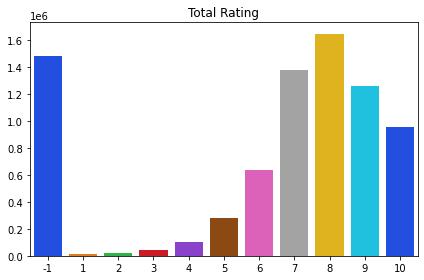

In [42]:
type_count = ratings['rating'].value_counts()
sns.barplot(x=type_count.index,
            y=type_count.values,
            palette='bright').set_title('Total Rating')
plt.tight_layout()
plt.show()

Pada hasil grafik diatas, menunjukkan bahwa terdapat ketidakseimbangan data yang dihasilkan, dimana pada data diatas menunjukan rating -1 yang sangat tinggi, sehingga diperlukan proses penanganan missing value.

###Handling Imbalanced Data

Melakukan penanganan ketidakseimbangan data, dengan cara menghapus rating yang bernilai -1.

In [43]:
ratings.drop(ratings[ratings['rating'] == -1].index, inplace=True)

In [44]:
ratings.shape

(6337241, 3)

In [45]:
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Melakukan pengecekan ulang mengenai missing value pada rating -1.

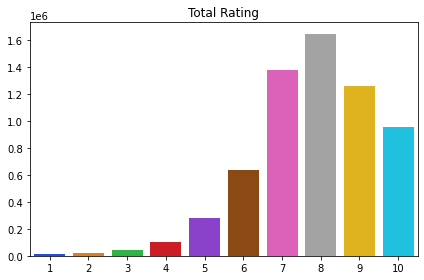

In [46]:
type_count =  ratings['rating'].value_counts()
sns.barplot(x=type_count.index,
            y=type_count.values,
            palette='bright').set_title('Total Rating')
plt.tight_layout()
plt.show()

melakukan persiapan data untuk menyandikan (encode) fitur ‘user’ dan ‘anime_id’

In [47]:
id_user = ratings['user_id'].unique().tolist()
print('list UserID: ', id_user)

user_to_user_encoded = {x: i for i, x in enumerate(id_user)}
print('encoded userID: ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(id_user)}
print('encoded angka ke userID: ', user_encoded_to_user)

list UserID:  [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 

In [48]:
#Mengubah anime_id menjadi list tanpa nilai yang sama
anime_ids = ratings['anime_id'].unique().tolist()

#Melakukan proses encoding anime_id
animeID_to_animeID_encoded = {x: i for i, x in enumerate(anime_ids)}

#Melakukan proses encoding angka ke anime_id
animeID_encoded_to_animeID = {i: x for i, x in enumerate(anime_ids)}

In [49]:
#Mapping userID ke dataframe user
ratings['user'] = ratings['user_id'].map(user_to_user_encoded)

#Mapping userID ke dataframe user
ratings['name'] = ratings['anime_id'].map(animeID_to_animeID_encoded)

In [50]:
ratings

,user_id,anime_id,rating,user,name
47,1,8074,10,0,0
81,1,11617,10,0,1
83,1,11757,10,0,2
101,1,15451,10,0,3
153,2,11771,10,1,4
...,...,...,...,...,...
7813732,73515,16512,7,69598,56
7813733,73515,17187,9,69598,1802
7813734,73515,22145,10,69598,783
7813735,73516,790,9,69599,753


In [51]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337241 entries, 47 to 7813736
Data columns (total 5 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
 3   user      int64
 4   name      int64
dtypes: int64(5)
memory usage: 290.1 MB


In [52]:
#Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

#Mendapatkan jumlah anime_id
num_anime = len(animeID_encoded_to_animeID)
print(num_anime)

#Mengubah rating menjadi nilai float
ratings['rating'] = ratings['rating'].values.astype(np.float32)

#Nilai minimum rating
min_rating = min(ratings['rating'])

#Nilai maksimal rating
max_rating = max(ratings['rating'])

print('Number of User: {}, Number of Anime: {}, Min Rating; {}, Max Rating: {}'. format(num_users, num_anime, min_rating, max_rating))

69600
9927
Number of User: 69600, Number of Anime: 9927, Min Rating; 1.0, Max Rating: 10.0


###Membagi Data untuk Training dan Validasi

In [53]:
#Mengacak dataset
ratings = ratings.sample(frac=1, random_state=42)
ratings

,user_id,anime_id,rating,user,name
5656992,53103,6707,7.0,50245,774
3552500,32884,339,8.0,31108,523
2636208,24907,23755,9.0,23560,80
5554182,52213,10156,7.0,49405,2505
95779,994,1562,10.0,934,790
...,...,...,...,...,...
1937731,18814,14713,7.0,17766,1427
2745907,25830,10397,8.0,24436,311
6086891,57108,12255,7.0,54062,2787
5325494,50462,226,9.0,47717,848


membagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan anime menjadi satu value terlebih dahulu. Lalu, membuat rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [54]:
x = ratings[['user', 'name']].values

#Membuat variabel y untuk membuat rating dari hasil
y = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

#Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
print(x, y)

[[50245   774]
 [31108   523]
 [23560    80]
 ...
 [54062  2787]
 [47717   848]
 [19096  1674]] [0.66666667 0.77777778 0.88888889 ... 0.66666667 0.88888889 0.33333333]


#**Modelling**

###Melakukan Proses Training

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = layers.Embedding( # layer embeddings resto
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [56]:
model = RecommenderNet(num_users, num_anime, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [57]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 128,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10
39608/39608 [==============================] - 1621s 41ms/step - loss: 0.6168 - root_mean_squared_error: 0.2076 - val_loss: 0.7026 - val_root_mean_squared_error: 0.2472
Epoch 2/10
39608/39608 [==============================] - 1567s 40ms/step - loss: 0.8031 - root_mean_squared_error: 0.2813 - val_loss: 0.8721 - val_root_mean_squared_error: 0.2974
Epoch 3/10
39608/39608 [==============================] - 1603s 40ms/step - loss: 0.9698 - root_mean_squared_error: 0.3159 - val_loss: 1.0086 - val_root_mean_squared_error: 0.3127
Epoch 4/10
39608/39608 [==============================] - 1551s 39ms/step - loss: 1.1089 - root_mean_squared_error: 0.3359 - val_loss: 1.1307 - val_root_mean_squared_error: 0.3180
Epoch 5/10
39608/39608 [==============================] - 1546s 39ms/step - loss: 1.2237 - root_mean_squared_error: 0.3462 - val_loss: 1.2331 - val_root_mean_squared_error: 0.3217
Epoch 6/10
39608/39608 [==============================] - 1550s 39ms/step - loss: 1.3218 - root_mean

#**Evaluation**

###Visualisasi Metrik

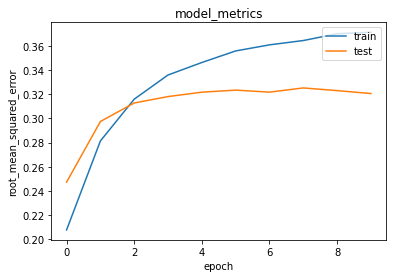

In [58]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [59]:
anime_df = animes
ratings = pd.read_csv('rating.csv')
 
# Mengambil sample user
user_id = ratings.user_id.sample(1).iloc[0]
anime_visited_by_user = ratings[ratings.user_id == user_id]
 

anime_not_visited = anime_df[~anime_df['anime_id'].isin(anime_visited_by_user.user_id.values)]['anime_id'] 
anime_not_visited = list(
    set(anime_not_visited)
    .intersection(set(animeID_to_animeID_encoded.keys()))
)
 
anime_not_visited = [[animeID_to_animeID_encoded.get(x)] for x in anime_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_visited), anime_not_visited)
)

In [60]:
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    animeID_encoded_to_animeID.get(anime_not_visited[x][0]) for x in top_ratings_indices

]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Anime with high ratings from user')
print('---' * 8)

top_anime_user = (
    anime_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values

)

anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
  print(row.name, ':', row.genre)

  print('----' * 8)
  print('Top 10 Anime Recommendation')
  print('----' * 8)

  recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
  for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

Showing recommendations for users: 60769
Anime with high ratings from user
------------------------
Fullmetal Alchemist: Brotherhood : Action, Adventure, Drama, Fantasy, Magic, Military, Shounen
--------------------------------
Top 10 Anime Recommendation
--------------------------------
Fullmetal Alchemist: Brotherhood : Action, Adventure, Drama, Fantasy, Magic, Military, Shounen
Gintama° : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Shigatsu wa Kimi no Uso : Drama, Music, Romance, School, Shounen
Code Geass: Hangyaku no Lelouch : Action, Mecha, Military, School, Sci-Fi, Super Power
Natsume Yuujinchou Shi : Drama, Fantasy, Shoujo, Slice of Life, Supernatural
Fate/Zero 2nd Season : Action, Fantasy, Supernatural, Thriller
JoJo no Kimyou na Bouken (TV) : Action, Adventure, Shounen, Supernatural, Vampire
Kuroko no Basket : Comedy, School, Shounen, Sports
Katekyo Hitman Reborn! : Action, Comedy, Shounen, Super Power
Danshi Koukousei no Nichijou : Comedy, School, Shounen, S

Dari output tersebut, kita dapat membandingkan antara Anime with high ratings from user dan Top 10 Anime recommendation untuk user.